# Final Project Team 17

Rene Gagnon A01757655
Oscar Lerma A01380817

As we all know, Alien vs. Predator is one of the best movie ever filmed and one of the most succesful too. Keeping that in mind, we decided to create a deep neural network to classify images in two categories: Alien or Predator.

## 1 - Packages

Let's first import all the packages that we will need during this project. 
- [numpy](www.numpy.org) is the fundamental package for scientific computing with Python.
- [matplotlib](http://matplotlib.org) is a library to plot graphs in Python.
- [h5py](http://www.h5py.org) is a common package to interact with a dataset that is stored on an H5 file.
- [PIL](http://www.pythonware.com/products/pil/) and [scipy](https://www.scipy.org/) are used here to test your model with your own picture at the end.
- dnn_app_utils provides the functions implemented in the "Building your Deep Neural Network: Step by Step" assignment to this notebook.
- np.random.seed(1) is used to keep all the random function calls consistent.
- glob is a python library to work with file paths

In [100]:
import time
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
import glob
from PIL import Image
from scipy import ndimage
from dnn_app_utils_v3 import *

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(1)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 2 - Dataset

In this section we load our dataset. Our dataset consists of 347 images of aliens and 347 images of predators, for a total of 694 examples. All images are in .jpg format, have a resolution of 200 by 200 pixels and are in seperate folders called "alien" and "predator". Aliens will labeled as 1 and predators as 0. Since the dataset is pretty large and we need to do some matrix operations to have it in the right format, loading it can take a minute or two.


In [101]:
# initialize image lists
alien_images_list = []
predator_images_list = []

#load alien images
for filename in glob.glob('alien-vs-predator-images/data/alien/*.jpg'):
    im=plt.imread(filename)
    alien_images_list.append(im)
    
#convert list to array
alien_images_array = np.stack(alien_images_list,axis=0)
alien_class_array = np.ones((1,347))

#load alien images
for filename in glob.glob('alien-vs-predator-images/data/predator/*.jpg'):
    im=plt.imread(filename)
    predator_images_list.append(im)
    
#convert list to array
predator_images_array = np.stack(predator_images_list,axis=0)
predator_class_array = np.zeros((1,347))

print(alien_images_array.shape)
print(predator_images_array.shape)

#concatenate two data sets and create class vector
image_dataset = np.concatenate((alien_images_array,predator_images_array),axis=0)
class_dataset = np.concatenate((alien_class_array,predator_class_array),axis=1)

#shuffle the dataset
randomize = np.arange(len(image_dataset))
np.random.shuffle(randomize)
image_dataset = image_dataset[randomize]
class_dataset = (class_dataset.transpose())[randomize].transpose()

print(image_dataset.shape)
print(class_dataset.shape)

(347, 200, 200, 3)
(347, 200, 200, 3)
(694, 200, 200, 3)
(1, 694)


The following code will show you an image in the dataset. Feel free to change the index and re-run the cell multiple times to see other images. 

y = 1. It's an alien picture.


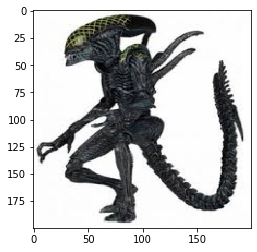

In [102]:
# Example of a picture
index = 78
plt.imshow(image_dataset[index])
if int(class_dataset[0,index]) == 1:
    print ("y = " + str(int(class_dataset[0,index])) + ". It's an alien picture.")
else:
    print ("y = " + str(int(class_dataset[0,index])) + ". It's a predator picture.")

Once we have loaded the whole dataset, we need to split in 3 parts: Training, Dev and Test. 600 examples will be used for training, 44 for dev and 50 for test. In each dataset, alien and predators are split evenly.

In [103]:
train_x_orig = np.concatenate((alien_images_array[:300],predator_images_array[:300]),axis=0)
train_y = np.array([np.concatenate((alien_class_array[0,:300],predator_class_array[0,:300]),axis=0)])
dev_x_orig = np.concatenate((alien_images_array[300:322],predator_images_array[300:322]),axis=0)
dev_y = np.array([np.concatenate((alien_class_array[0,300:322],predator_class_array[0,300:322]),axis=0)])
test_x_orig = np.concatenate((alien_images_array[322:],predator_images_array[322:]),axis=0)
test_y = np.array([np.concatenate((alien_class_array[0,322:],predator_class_array[0,322:]),axis=0)])

In [104]:
# Explore the dataset 

print ("Number of training examples: " + str(train_x_orig.shape[0]))
print ("Number of dev examples: " + str(dev_x_orig.shape[0]))
print ("Number of testing examples: " + str(test_x_orig.shape[0]))
print ("Each image is of size: (" + str(train_x_orig.shape[1]) + ", " + str(train_x_orig.shape[2]) + ", " + str(train_x_orig.shape[3])+ ")")
print ("train_x_orig shape: " + str(train_x_orig.shape))
print ("train_y shape: " + str(train_y.shape))
print ("dev_x_org shape: " + str(dev_x_orig.shape))
print ("dev_y shape: " + str(dev_y.shape))
print ("test_x_orig shape: " + str(test_x_orig.shape))
print ("test_y shape: " + str(test_y.shape))

Number of training examples: 600
Number of dev examples: 44
Number of testing examples: 50
Each image is of size: (200, 200, 3)
train_x_orig shape: (600, 200, 200, 3)
train_y shape: (1, 600)
dev_x_org shape: (44, 200, 200, 3)
dev_y shape: (1, 44)
test_x_orig shape: (50, 200, 200, 3)
test_y shape: (1, 50)


As usual, you reshape and standardize the images before feeding them to the network. The code is given in the cell below.

<img src="images/imvectorkiank.png" style="width:450px;height:300px;">

<caption><center> <u>Figure 1</u>: Image to vector conversion. <br> </center></caption>

In [105]:
# Reshape the training and test examples 
train_x_flatten = train_x_orig.reshape(train_x_orig.shape[0], -1).T   # The "-1" makes reshape flatten the remaining dimensions
dev_x_flatten = dev_x_orig.reshape(dev_x_orig.shape[0], -1).T
test_x_flatten = test_x_orig.reshape(test_x_orig.shape[0], -1).T

# Standardize data to have feature values between 0 and 1.
train_x = train_x_flatten/255.
dev_x = dev_x_flatten/255.
test_x = test_x_flatten/255.

print ("train_x's shape: " + str(train_x.shape))
print ("dev_x's shape: " + str(dev_x.shape))
print ("test_x's shape: " + str(test_x.shape))


train_x's shape: (120000, 600)
dev_x's shape: (120000, 44)
test_x's shape: (120000, 50)


$120,000$ equals $200 \times 200 \times 3$ which is the size of one reshaped image vector.

## 3 - Architecture of the model

Now that we have loaded the dataset, splitted it, are familiar with and that it is normalized, we are ready to implement the L layer architecture. Below is the theory behind the deep learning architecture we are going to use. 

Note: The architectures shows an L layer network for cat images of 64x64x3, we adapted it to work with our dataset of alien images of 200x200x3.

### L-layer deep neural network

It is hard to represent an L-layer deep neural network with the above representation. However, here is a simplified network representation:

<img src="images/LlayerNN_kiank.png" style="width:650px;height:400px;">
<caption><center> <u>Figure 3</u>: L-layer neural network. <br> The model can be summarized as: ***[LINEAR -> RELU] $\times$ (L-1) -> LINEAR -> SIGMOID***</center></caption>

<u>Detailed Architecture of figure 3</u>:
- The input is a (64,64,3) image which is flattened to a vector of size (12288,1).
- The corresponding vector: $[x_0,x_1,...,x_{12287}]^T$ is then multiplied by the weight matrix $W^{[1]}$ and then you add the intercept $b^{[1]}$. The result is called the linear unit.
- Next, you take the relu of the linear unit. This process could be repeated several times for each $(W^{[l]}, b^{[l]})$ depending on the model architecture.
- Finally, you take the sigmoid of the final linear unit. If it is greater than 0.5, you classify it to be a cat.

### General methodology
This is the main steps the algorithm uses:

    1. Initialize parameters / Define hyperparameters
    2. Loop for num_iterations:
        a. Forward propagation
        b. Compute cost function
        c. Backward propagation
        d. Update parameters (using parameters, and grads from backprop) 
    3. Use trained parameters to predict labels


To help us with our implementation we use functions that we developed earlier in the course:

```python
def initialize_parameters_deep(layers_dims):
    ...
    return parameters 
def L_model_forward(X, parameters):
    ...
    return AL, caches
def compute_cost(AL, Y):
    ...
    return cost
def L_model_backward(AL, Y, caches):
    ...
    return grads
def update_parameters(parameters, grads, learning_rate):
    ...
    return parameters
```

To improve our algoritm we decided to include the He initialization that we saw in homework 9. This should allow us to have decent performance from the DNN with a minimal number of iterations.

In [106]:
def initialize_parameters_he(layers_dims):
    """
    Arguments:
    layer_dims -- python array (list) containing the size of each layer.
    
    Returns:
    parameters -- python dictionary containing your parameters "W1", "b1", ..., "WL", "bL":
                    W1 -- weight matrix of shape (layers_dims[1], layers_dims[0])
                    b1 -- bias vector of shape (layers_dims[1], 1)
                    ...
                    WL -- weight matrix of shape (layers_dims[L], layers_dims[L-1])
                    bL -- bias vector of shape (layers_dims[L], 1)
    """
    
    np.random.seed(3)
    parameters = {}
    L = len(layers_dims) - 1 # integer representing the number of layers
     
    for l in range(1, L + 1):
        ### START CODE HERE ### (≈ 2 lines of code)
        parameters['W' + str(l)] = np.random.randn(layers_dims[l],layers_dims[l-1]) * np.sqrt(2/layers_dims[l-1])
        parameters['b' + str(l)] = np.zeros((layers_dims[l],1))
        ### END CODE HERE ###
        
    return parameters

We decided to keep the same number of layers and number of neurons per layer as in homework 8 since this architecture worked well for image classification and image classification is what our network is supposed to do.

In [107]:
### CONSTANTS ###
layers_dims = [120000, 20, 7, 5, 1] #  4-layer model

Now let's implement our Deep Neural Network!

In [108]:
# L_layer_model

def L_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 500, print_cost=False):
    """
    Implementation of a L-layer neural network: [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID.
    
    Arguments:
    X -- data, numpy array of shape (number of examples, num_px * num_px * 3)
    Y -- true "label" vector (containing 1 if alien and 0 is predator), of shape (1, number of examples)
    layers_dims -- list containing the input size and each layer size, of length (number of layers + 1).
    learning_rate -- learning rate of the gradient descent update rule
    num_iterations -- number of iterations of the optimization loop
    print_cost -- if True, it prints the cost every 100 steps
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """

    np.random.seed(1)
    costs = []                         # keep track of cost
    
    # Parameters initialization. (≈ 1 line of code)
    ### START CODE HERE ###
    parameters = initialize_parameters_he(layers_dims)
    ### END CODE HERE ###
    
    # Loop (gradient descent)
    for i in range(0, num_iterations):

        # Forward propagation: [LINEAR -> RELU]*(L-1) -> LINEAR -> SIGMOID.
        ### START CODE HERE ### (≈ 1 line of code)
        AL, caches = L_model_forward(X, parameters)
        ### END CODE HERE ###
        
        # Compute cost.
        ### START CODE HERE ### (≈ 1 line of code)
        cost = compute_cost(AL, Y)
        ### END CODE HERE ###
    
        # Backward propagation.
        ### START CODE HERE ### (≈ 1 line of code)
        grads = L_model_backward(AL, Y, caches)
        ### END CODE HERE ###
 
        # Update parameters.
        ### START CODE HERE ### (≈ 1 line of code)
        parameters = update_parameters(parameters, grads, learning_rate)
        ### END CODE HERE ###
                
        # Print the cost every 50 training example
        if print_cost and i % 50 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
        if print_cost and i % 100 == 0:
            costs.append(cost)
            
    # plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

We will now train the model as a 4-layer neural network. Since the training set is relatively large (600), the images relatively big (200 by 200 pixels) and we do not have super computers powerful computers at our disposition, the training takes a lot of time. For a 1000 iterations it can take up to 15 minutes to train the network, so be patient!



Cost after iteration 0: 0.708459
Cost after iteration 50: 0.674792
Cost after iteration 100: 0.660759
Cost after iteration 150: 0.646537
Cost after iteration 200: 0.630998
Cost after iteration 250: 0.613811
Cost after iteration 300: 0.609588
Cost after iteration 350: 0.595799
Cost after iteration 400: 0.587584
Cost after iteration 450: 0.576543
Cost after iteration 500: 0.555546
Cost after iteration 550: 0.530185
Cost after iteration 600: 0.491265
Cost after iteration 650: 0.484821
Cost after iteration 700: 0.538223
Cost after iteration 750: 0.581044
Cost after iteration 800: 0.470138
Cost after iteration 850: 0.515413
Cost after iteration 900: 0.375235
Cost after iteration 950: 0.592982
Cost after iteration 1000: 0.505847
Cost after iteration 1050: 0.338607
Cost after iteration 1100: 0.322498
Cost after iteration 1150: 0.402001
Cost after iteration 1200: 0.301823
Cost after iteration 1250: 0.246763
Cost after iteration 1300: 0.325081
Cost after iteration 1350: 0.230013
Cost after iter

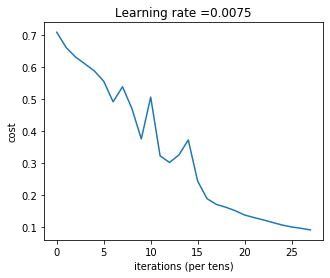

In [109]:
parameters = L_layer_model(train_x, train_y, layers_dims, learning_rate = 0.0075, num_iterations = 2750, print_cost = True)

Now let's test our fresly learned parameters on the training set and the dev set! Testing against the training set will make sure that we have a reasonable accuracy (low bias). We will use the accuracy obtained in the dev set to compare with the training set accuracy. We want to make sure that these two accuracy are very similar (low variance)

In [110]:
pred_train = predict(train_x, train_y, parameters)

Accuracy: 0.9966666666666667


In [111]:
pred_dev = predict(dev_x, dev_y, parameters)

Accuracy: 0.6136363636363636


Now that we have tweaked our hyper parameters using the training and dev set to obtain the lowest possible bias and variance, we can test our model with the test set.

In [112]:
pred_test = predict(test_x, test_y, parameters)

Accuracy: 0.7


The highest performance of we achieved was 70 %.

##  4) Results Analysis

Now that we have tested our network, let's take a look at some images the L-layer model labeled incorrectly. This will give us insight as to the possible weaknesses of our model or dataset are.

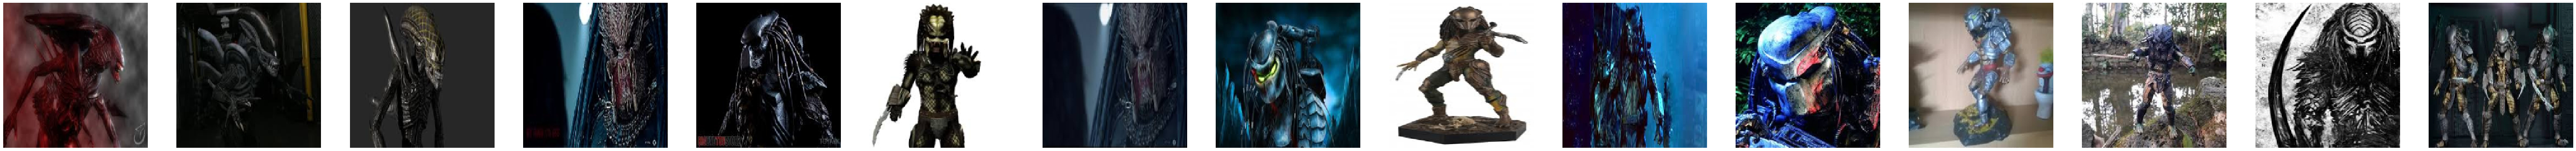

In [113]:
plt.rcParams['figure.figsize'] = (100.0, 100.0) # set default size of plots
a = pred_test + test_y
mislabeled_indices = np.asarray(np.where(a == 1))
num_images = len(mislabeled_indices[0])
for i in range(num_images):
        index = mislabeled_indices[1][i]
        
        plt.subplot(2, num_images, i + 1)
        plt.imshow(test_x[:,index].reshape(200,200,3), interpolation='nearest')
        plt.axis('off')
        #plt.title("Prediction: " + str(pred_test[0,index]) + " \n Class: " + str(test_y[0,index])

We can observe a few things that might have confused our deep neural network:
* Sometimes contrast is really poor which make it hard to see the shape and features of the character
* Aliens are often in various orientation (sideways, upside down or front facing)
* Alien and predators are often not represented on the same scale or in their entirety (i.e. only the head is visible)
* We can see an image of multiple predators which is uncommon in our dataset, usually images contain one alien or one predator